# **1. Objective**
To **classify** images of food to identify which are pizzas are which are not pizzas. It is a **binary classification**

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize']=(20,20)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# **2. Looking at the Images**

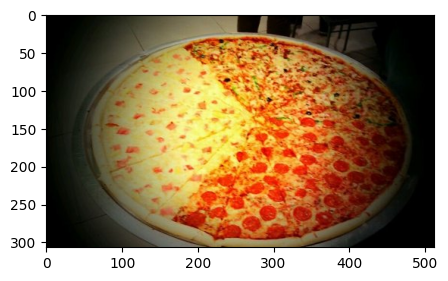

In [2]:
from glob import glob #retriving an array of files in directories
path_train = "/kaggle/input/pizza-not-pizza/pizza_not_pizza"
img = glob(path_train+"/pizza/*.jpg")
# print(img)
img = np.asarray(plt.imread(img[0]))
plt.figure(figsize = (5 , 5))
plt.imshow(img)

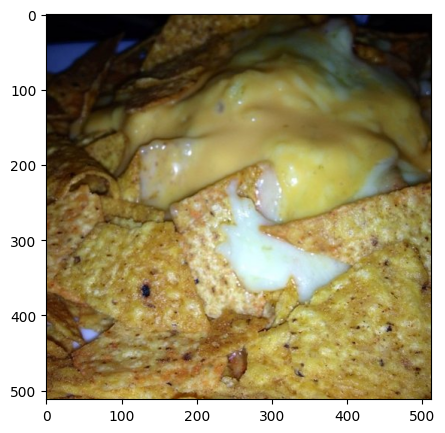

In [3]:
img = glob(path_train+"/not_pizza/*.jpg")
img = np.asarray(plt.imread(img[0]))
plt.figure(figsize = (5 , 5))
plt.imshow(img)

# **3. Acquiring our Dataset from the Directories**

In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array

In [6]:
from tensorflow.keras.models import Sequential,Model

In [7]:
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Input,MaxPooling2D,Dropout,BatchNormalization

**Using ImageDataGenerator we load the images to our model**

In [8]:
img_size = 224
batch_size=32

datagen = ImageDataGenerator(rescale=1/255.,
                             shear_range=0.2,
                             zoom_range=0.2,
                             validation_split = 0.2,
                             rotation_range=30,
                             horizontal_flip=True)

**Segregation of our Data to Training and Validation**

In [9]:
traindata = datagen.flow_from_directory("/kaggle/input/pizza-not-pizza/pizza_not_pizza",
                                             target_size=(224,224),
                                             batch_size=32,
                                             subset='training',
                                             class_mode='binary')

valdata = datagen.flow_from_directory("/kaggle/input/pizza-not-pizza/pizza_not_pizza",
                                             target_size=(224,224),
                                             batch_size=32,
                                             subset='validation',
                                             class_mode='binary')

Found 1574 images belonging to 2 classes.
Found 392 images belonging to 2 classes.


**Generating Visual Representation of the Training Dataset**

In [10]:
labels=['Not Pizza','Pizza']
samples=traindata.__next__()

images=samples[0]
target=samples[1]

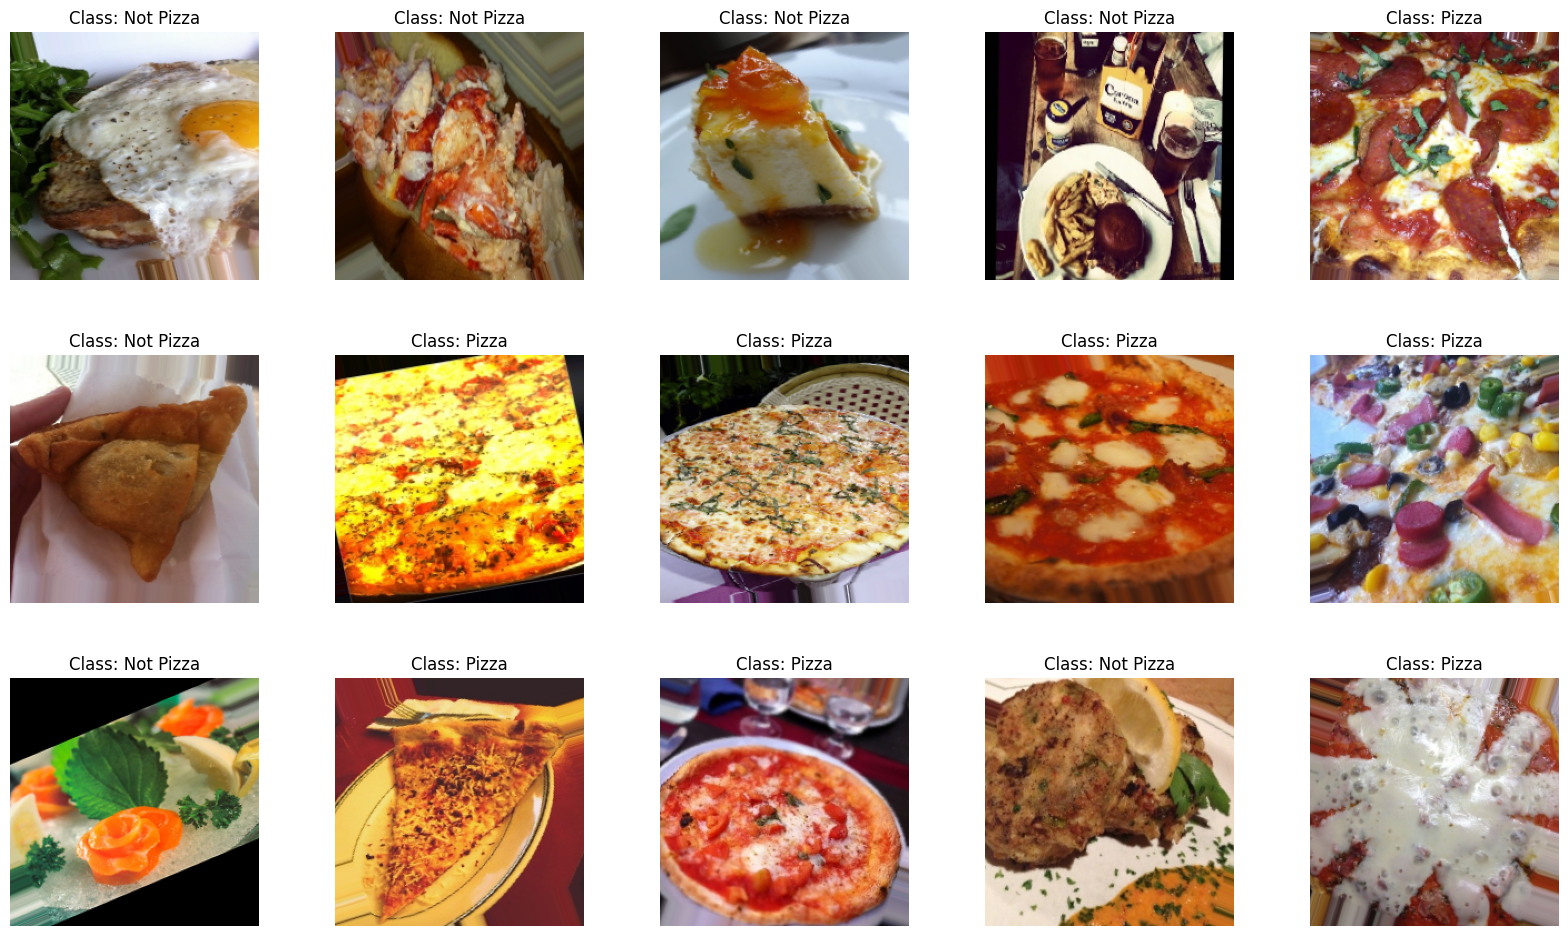

In [11]:
for i in range(15):
    plt.subplot(5,5,i+1)
    plt.subplots_adjust(hspace=0.3,wspace=.3)
    plt.imshow(images[i])
    plt.title(f"Class: {labels[int(target[i])]}")
    plt.axis('off')

# **4. Creating the Convolutional Neural Network**

In [12]:
model=Sequential() #Layer by layer NN starts here
model.add(Conv2D(32,(2,2),input_shape=(img_size,img_size,3),activation="relu",padding='valid',strides=1))
#32 Filters of size 2x2, input shape of the image in given size and grayscale, using relu activation function, stride is the step size
model.add(MaxPooling2D((2,2)))
#Pooling and decreasing of the dimensions
model.add(Conv2D(64,(2,2),strides=2,activation="relu",padding="valid"))
#64 filters and larger strides of 2
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128,(2,2), strides=1,activation="relu",padding='valid'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(256,(2,2), strides=1,activation="relu",padding='valid'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(512,(2,2), strides=1,activation="relu",padding='valid'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
#Flattens the previous layer, converting the multi-dimentional image to a complete single-dimension
model.add(Dense(128,activation="relu"))
#Fully connected network with 128 neurons
model.add(Dense(1,activation='sigmoid'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 223, 223, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 55, 55, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 27, 27, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 128)       32896     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 128)       0

In [14]:
model.compile(optimizer = 'adam', loss='binary_crossentropy',metrics=['accuracy'])

**Checkpoints**
* **ModelCheckpoint** callback is used in conjunction with training using model. fit() to save a model or weights in a checkpoint file at some time, so the model or weights can be loaded later to continue the training from the state saved.
* **EarlyStopping** is a method that allows you to specify an arbitrary large number of training epochs and stop training once the model performance stops improving on a hold out validation dataset
* **ReduceLROnPlatrau** adjusts the models Learing Rate dynamically depending on how the model is performing on the validation dataset. The metric to evaluate it's performance is val_loss.

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
filepath = "model_cnn.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=False)
reduceLR = ReduceLROnPlateau( monitor='val_loss',
                                factor=0.2,
                                patience=3,
                                verbose=1,
                                mode='auto',
                                min_delta=0.0001,
                                min_lr = 0.00000001)
early_stop = EarlyStopping(monitor='val_loss',
                            min_delta=0,
                            patience=5,
                            verbose=1,
                            mode='auto',
                            start_from_epoch=0)

# **5. Training the Model**

In [16]:
history=model.fit(traindata,batch_size=32,epochs=100,validation_data=valdata,verbose=1,callbacks=[checkpoint, early_stop, reduceLR])

Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 0.6973 - accuracy: 0.5241
Epoch 1: val_loss improved from inf to 0.68506, saving model to model_cnn.h5
50/50 [==============================] - 45s 702ms/step - loss: 0.6973 - accuracy: 0.5241 - val_loss: 0.6851 - val_accuracy: 0.6454 - lr: 0.0010
Epoch 2/100


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 [==============================] - ETA: 0s - loss: 0.6829 - accuracy: 0.5654
Epoch 2: val_loss improved from 0.68506 to 0.64717, saving model to model_cnn.h5
50/50 [==============================] - 24s 476ms/step - loss: 0.6829 - accuracy: 0.5654 - val_loss: 0.6472 - val_accuracy: 0.6658 - lr: 0.0010
Epoch 3/100
50/50 [==============================] - ETA: 0s - loss: 0.6584 - accuracy: 0.6112
Epoch 3: val_loss improved from 0.64717 to 0.60335, saving model to model_cnn.h5
50/50 [==============================] - 23s 470ms/step - loss: 0.6584 - accuracy: 0.6112 - val_loss: 0.6033 - val_accuracy: 0.6862 - lr: 0.0010
Epoch 4/100
50/50 [==============================] - ETA: 0s - loss: 0.6110 - accuracy: 0.6665
Epoch 4: val_loss improved from 0.60335 to 0.58046, saving model to model_cnn.h5
50/50 [==============================] - 23s 470ms/step - loss: 0.6110 - accuracy: 0.6665 - val_loss: 0.5805 - val_accuracy: 0.7219 - lr: 0.0010
Epoch 5/100
50/50 [==============================

# **6. Evaluation of the Training of the Model**

**Plot of loss and val_loss**

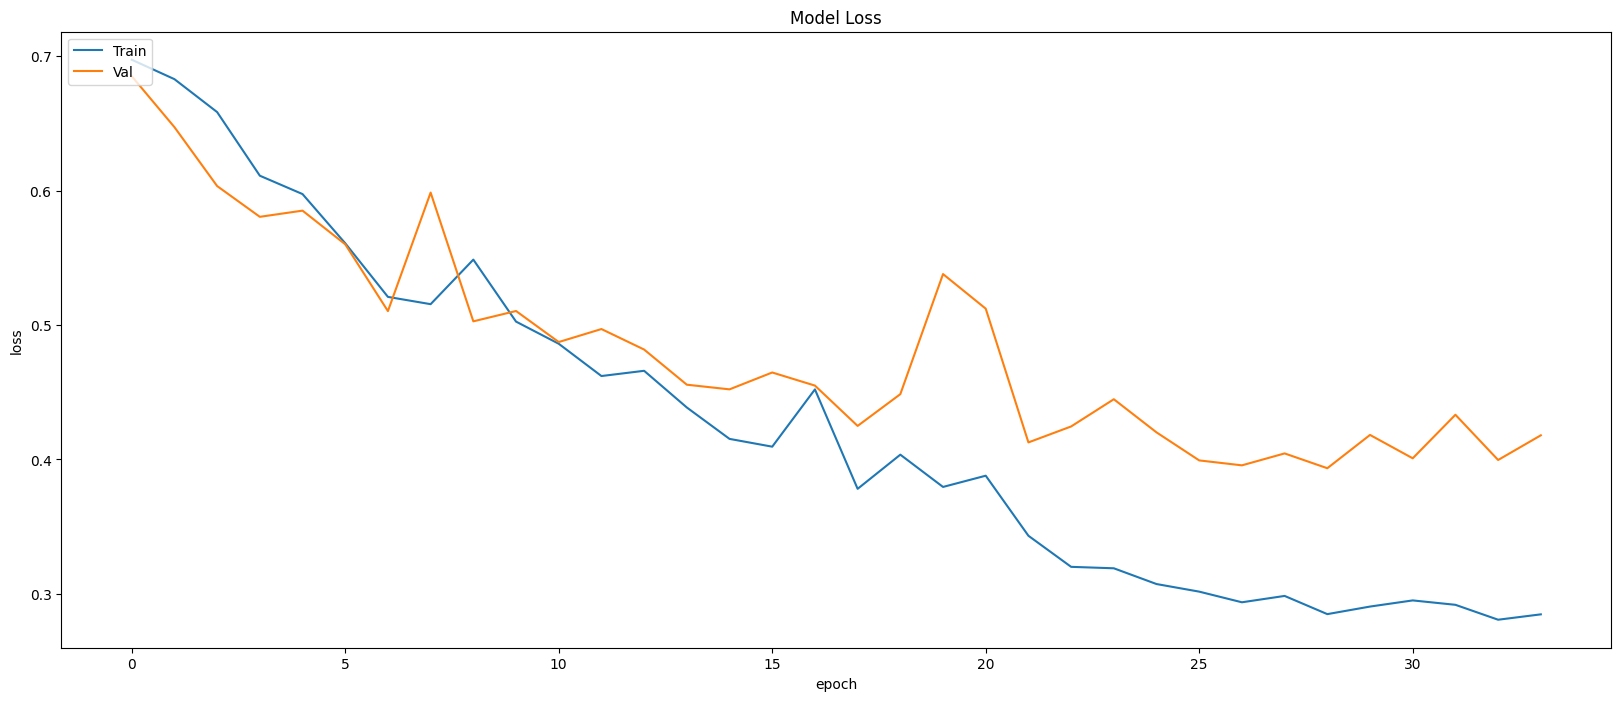

In [17]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
#plot the training loss over every epoch
plt.plot(history.history['val_loss'])
#plot the validation loss
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Val'],loc='upper left')
plt.show()

**Plot of accuracy and val_accuracy**

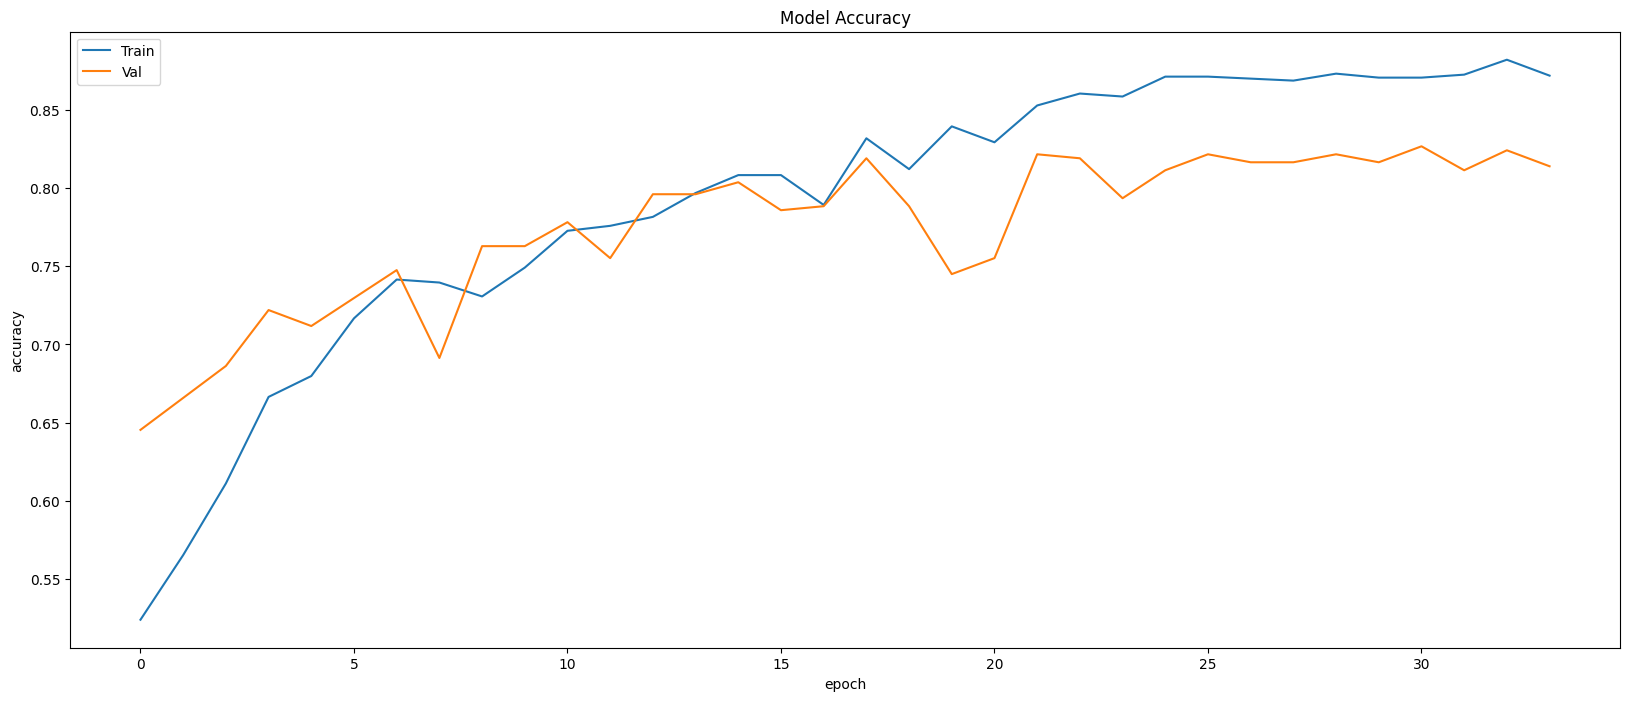

In [18]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
#plot the training accuracy over all the epochs
plt.plot(history.history['val_accuracy'])
#plot the validation accuracy over all the epochs
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Val'],loc='upper left')
plt.show()